In [1]:
import cv2
import torch
from Encoding import *
from matplotlib import pyplot as plt
from pymonntorch import *
import numpy as np
from timeRes import TimeResolution
from current import *
from lif import LIF, InputPattern
from synapse import *
from connections import Connections
from learning import *

In [2]:
def image_to_vec(address, size=(10, 10)):
    img = cv2.imread(address)
    img = cv2.resize(img, (size[0], size[1]))
    img = torch.from_numpy(img)
    img = img.sum(2)//3

    return img

In [3]:
img1 = image_to_vec('lena1.tif')
img2 = image_to_vec('circles.tif')
# ttfs = TimeToFirstSpikeEncoding(img, 100, 400)
# spikes = ttfs.encode()
# for i in range(spikes.shape[0]):
#     for j in range(spikes.shape[1]):
#         print(spikes[i][j].item(), end=" ")
#     print()

ge1 = PoissonEncoder(img1, 150)
spikes1 = ge1.encode()
ge2 = PoissonEncoder(img2, 150)
spikes2 = ge2.encode()
# ge = PositionEncoder(img, 10, 3)
# spikes = ge.encode()
# ge.encode()
# print(spikes)
# ge = GaussianEncoding(10, 100, img)
# ge.encode()


In [4]:
def raster(s_exc: torch.Tensor = [], s_inh: torch.Tensor = []):
    
    plt.figure(figsize=(5,5))
    plt.xlim(0, len(s_exc))
    if s_exc != []:
        exc = torch.nonzero(s_exc)
        plt.scatter(exc[:,0], exc[:,1], s=1, c='darkviolet')
    if s_inh != []:
        inh = torch.nonzero(s_inh)
        if s_exc != []:
            inh[:,1] += s_exc.size(1)
        plt.scatter(inh[:,0], inh[:,1], s=1, c='fuchsia')
        
    plt.xlabel("Neurons")
    plt.ylabel("Time")
    # plt.title("Raster Plot "+label)
    plt.show()

In [5]:
def fill_pattern(pattern, n_free, is_right=True):
    pattern = pattern.transpose(-2, 1)
    shape = pattern.shape
    new_pattern = torch.zeros(shape[0]+n_free, shape[1])
    if is_right:
        for i in range(pattern.shape[0]):
            for j in range(pattern.shape[1]):
                new_pattern[i][j] = pattern[i][j] 
    else:
        for i in range(pattern.shape[0]):
            for j in range(pattern.shape[1]):
                new_pattern[i+n_free][j] = pattern[i][j]

    return new_pattern


In [6]:
pattern1 = fill_pattern(spikes1, 0)
pattern2 = fill_pattern(spikes2, 0, False)

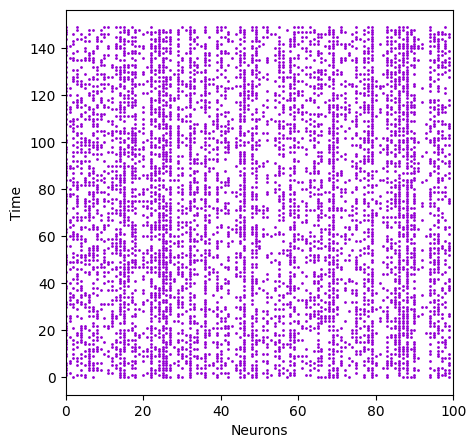

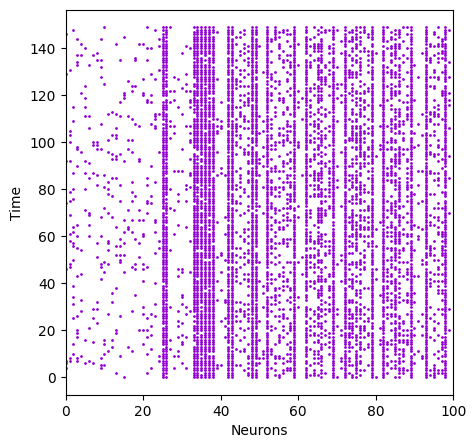

In [7]:
# spikes1 = spikes1.transpose(-2, 1)
raster(pattern1)
# spikes2 = spikes2.transpose(-2, 1)
raster(pattern2)

In [8]:
pattern1 = pattern1.transpose(-2, 1)
pattern2 = pattern2.transpose(-2, 1)

In [9]:

net = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
input_ng = NeuronGroup(
    100,
    net=net,
    behavior={
        7: InputPattern(pattern=pattern1, pattern2=pattern2, cpt=200, sleep=50),
    },
    tag="inp_NG1",
)


output_ng = NeuronGroup(
    3,
    net=net,
    behavior={
        2: ConstantCurrent(value=0),
        5: InpSyn(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-35,
            R=5,
            N=2,
        ),
        9: Recorder(variables=["v", "I"], tag="inh_ng1_rec, inh_ng1_recorder"),
        10: EventRecorder("spike", tag="inh_ng1_evrec"),
    },
    tag="out_NG2",
)

connect_inp_out = SynapseGroup(net=net,
                src=input_ng, 
                dst=output_ng, 
                behavior={
                    3: SynFun(),
                    4: STDP(),
                    5: Connections(def_val=20, type="full"),    
                    11: Recorder(variables=["W"], tag="layers weights"),  
                })


In [15]:
indexesi = [random.randint(0, 150) for _ in range(20)]
indexesj = [random.randint(0, 100) for _ in range(20)]

k = 0
for i in range(20):
    if pattern1[indexesi[k]][indexesj[k]]:
        pattern1[indexesi[k]][indexesj[k]] = False
    else:
        pattern1[indexesi[k]][indexesj[k]] = True
    k += 1
        

In [18]:
net = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
input_ng = NeuronGroup(
    100,
    net=net,
    behavior={
        7: InputPattern(pattern=pattern1, pattern2=pattern2, cpt=200, sleep=50),
    },
    tag="inp_NG1",
)


output_ng = NeuronGroup(
    3,
    net=net,
    behavior={
        2: ConstantCurrent(value=10),
        5: InpSyn(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-35,
            R=5,
            N=2,
        ),
        9: Recorder(variables=["v", "I"], tag="inh_ng1_rec, inh_ng1_recorder"),
        10: EventRecorder("spike", tag="inh_ng1_evrec"),
    },
    tag="out_NG2",
)

connect_inp_out = SynapseGroup(net=net,
                src=input_ng, 
                dst=output_ng, 
                behavior={
                    3: SynFun(),
                    4: STDP(),
                    5: Connections(def_val=20, type="full"),    
                    11: Recorder(variables=["W"], tag="layers weights"),  
                })


In [19]:
net.initialize()
net.simulate_iterations(150)

Network['Network_1', 'Network'](Neurons: tensor(103)|2 groups, Synapses: tensor(300)|1 groups){1:TimeResolution()}
NeuronGroup['inp_NG1', 'NeuronGroup', 'ng'](100){7:InputPattern(pattern=tensor([[0., 0., 1.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 1., 1., 0.],
        [1., 1., 0.,  ..., 0., 1., 1.],
        ...,
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.]]),pattern2=tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]]),cpt=200,sleep=50,)}
NeuronGroup['out_NG2', 'NeuronGroup', 'ng'](3){2:ConstantCurrent(value=10,)5:InpSyn()7:LIF(tau=10,u_rest=-65,u_reset=-73.42,threshold=-35,R=5,N=2,)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=inh_ng1_rec, inh_ng1_recorder,)10:EventRecorde

1670.4905033111572

In [23]:
column1 = net["W", 0][-1][:][0]  # First column
column2 = net["W", 0][-1][:][1]  # First column
# column2 = matrix[:, 1]  # Second column

# Calculate dot product
dot_product = np.dot(column1, column2)

# Calculate magnitudes
magnitude1 = np.linalg.norm(column1)
magnitude2 = np.linalg.norm(column2)

# Calculate cosine similarity
cosine_similarity = dot_product / (magnitude1 * magnitude2)
print(cosine_similarity)

0.9998555221171452


torch.Size([150, 100, 3])


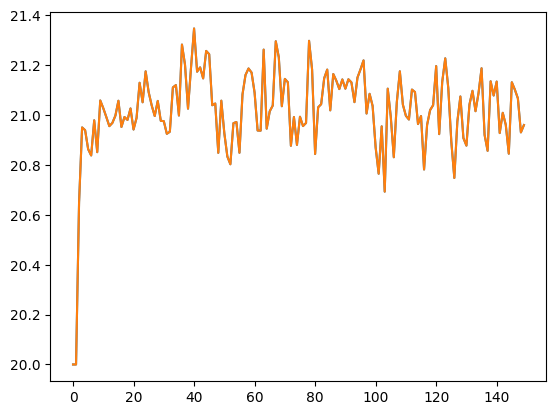

In [21]:
print(net["W", 0].shape)
vars1 = []
vars2 = []
for i in range(150):
    sum1 = 0
    sum2 = 0
    for j in range(100):
        sum1 += net["W", 0][i][j][1]
        sum2 += net["W", 0][i][j][0]
    vars1.append(sum1/100)
    vars2.append(sum2/100)

time = [i for i in range(150)]
plt.plot(time, vars1)
plt.plot(time, vars2)
# # plt.plot(vars2, label="exc2")
# # plt.plot(vars3, label="inh")
# plt.xlabel("time")
# plt.ylabel("v")
# plt.legend()
# plt.show()